In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten, Conv2DTranspose, Conv2D
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import numpy as np

In [ ]:
#generating autoencoder noise corresponding to every instance
X_train=pickle.load(open('drive/MyDrive/X_train.pkl','rb'))
X_train = (X_train.astype(np.float32)-127.5)/127.5
encoder=load_model('drive/MyDrive/encoder.h5')
X_train_noise=encoder.predict(X_train)

In [ ]:
#defining input image dimensions
rows=120
cols=160
channels=3
img_shape = (rows,cols,channels)

In [ ]:
#building a generator
def build_generator():
  noise_shape = (100,) #1D latent vector of size 100 - Input to generator
  #building the model
  model=Sequential()
  model.add(Dense(30*40*128,input_shape=noise_shape))
  model.add(Reshape((30,40,128)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Conv2DTranspose(64,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Conv2DTranspose(3,(3,3),strides=(2,2),padding='same',activation='tanh'))
  
  model.summary()

  noise=Input(shape=noise_shape)
  img=model(noise) #Generated image

  return Model(noise,img)

In [ ]:
#building a discriminator
def build_discriminator():
  model=Sequential()
  model.add(Conv2D(64,kernel_size=(3,3),strides=(2,2),padding='same',input_shape=img_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,kernel_size=(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dense(100))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1,activation='sigmoid'))
  model.summary()

  img=Input(shape=img_shape)
  validity=model(img)

  return Model(img,validity)

In [ ]:
disc_loss=[]
gen_loss=[]

In [ ]:
def train(epochs,batch_size,save_interval):
  #loading dataset
  X_train=pickle.load(open('drive/MyDrive/X_train.pkl','rb'))
  #rescaling the images
  X_train = (X_train.astype(np.float32)-127.5)/127.5

  for epoch in range(epochs+1):
    '''
    train discriminator
    '''
    #select random batch of real images
    id=np.random.randint(0,X_train.shape[0],batch_size)
    imgs=X_train[id]

    #generate batch of fake images
    idn=np.random.randint(0,X_train_noise.shape[0],batch_size)
    gen_imgs=generator.predict(X_train_noise[idn])
    #discriminator loss
    d_loss_real=discriminator.train_on_batch(imgs,np.ones((batch_size,1)))
    d_loss_fake=discriminator.train_on_batch(gen_imgs,np.zeros((batch_size,1)))
    d_loss=0.5*np.add(d_loss_real,d_loss_fake)
    disc_loss.append(d_loss[0])
    '''
    train generator
    '''
    idn=np.random.randint(0,X_train_noise.shape[0],batch_size)
    noise=X_train_noise[idn]
    valid_y=np.array([1]*batch_size)
    #generator loss
    g_loss=combined.train_on_batch(noise,valid_y)
    gen_loss.append(g_loss)
    
    print(epoch,' ',d_loss[0],' ',g_loss)

    #saving images
    if epoch%save_interval==0:
      save_imgs(epoch)

In [ ]:
def save_imgs(epoch):
  r,c=5,5
  idn=np.random.randint(0,X_train_noise.shape[0],r*c)
  noise=X_train_noise[idn]
  gen_imgs=generator.predict(noise)
  #rescale images 0-1
  gen_imgs=0.5*gen_imgs+0.5
  
  fig,axs=plt.subplots(r,c)
  cnt=0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt,:,:,:])
      axs[i,j].axis('off')
      cnt+=1
  fig.savefig("drive/MyDrive/images_autoencode/NUS_I_%d.png"%epoch)
  generator.save('drive/MyDrive/GAN_autoencoder_models_NUS_I/generator_model_test_autoencode_NUS_I%d.h5'%epoch)
  plt.close()

In [ ]:
#choosing the optimizer
optimizer=Adam(0.0002,0.5)

#building the discriminator
discriminator=build_discriminator()
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

#building the generator
generator=build_generator()

#input vector
z=Input(shape=(100,))
img=generator(z)

discriminator.trainable=False

#validity from discriminator
valid=discriminator(img)

#building combined modeel
combined=Model(z,valid)
combined.compile(loss='binary_crossentropy',optimizer=optimizer)

#training the GAN
train(epochs=10000,batch_size=16,save_interval=500)

#saving the generator
generator.save('drive/MyDrive/generator_model_test_autoencode_NUS_I.h5')


Streaming output truncated to the last 5000 lines.
5012   0.0354141837451607   6.676301002502441
5013   0.04172527976334095   5.741267681121826
5014   0.02228225814178586   7.327496528625488
5015   0.007963577518239617   7.747848033905029
5016   0.004022686742246151   8.975732803344727
5017   0.02668469026684761   5.90925407409668
5018   0.006226905155926943   6.57878303527832
5019   0.03422954119741917   5.199636936187744
5020   0.059261541813611984   5.362307071685791
5021   0.022340635303407907   6.724369525909424
5022   0.013549559749662876   7.9760284423828125
5023   0.01607587467879057   6.734421730041504
5024   0.006698896177113056   8.541790008544922
5025   0.00838789390400052   6.556116580963135
5026   0.010904202237725258   6.355757713317871
5027   0.013529965188354254   5.473573684692383
5028   0.01307225413620472   6.379701614379883
5029   0.05648472160100937   6.44915771484375
5030   0.02344432659447193   5.869541168212891
5031   0.033497444819658995   5.740809440612793
50

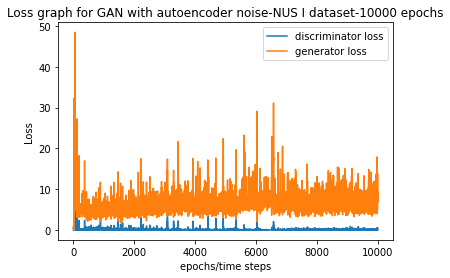

In [ ]:
import matplotlib.pyplot as plt
plt.plot(disc_loss,label='discriminator loss')
plt.plot(gen_loss,label='generator loss')
plt.xlabel('epochs/time steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss graph for GAN with autoencoder noise-NUS I dataset-10000 epochs')
plt.show()

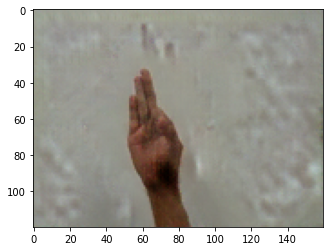

In [ ]:
#Generating random image
from numpy.random import randn
gm=load_model('drive/MyDrive/generator_model_test_autoencode_NUS_I.h5')
id=np.random.randint(0,X_train_noise.shape[0],1)
vector=X_train_noise[id]
image=gm.predict(vector)
image=image*0.5+0.5
plt.imshow(image[0,:,:,:])